
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Interactive Spatial Data Declustering Demonstration


### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### The Interactive Workflow

Here's a simple workflow for calculating and evaluating spatial data declustering weights smapling bias due to clustered sampled mitigation.


### Basic Univariate Summary Statistics and Data Distribution Representativity Plotting in Python with GeostatsPy

Here's a simple workflow with some basic univariate statistics and distribution representativity. This should help you get started data declustering to address spatial sampling bias.

#### Geostatistical Sampling Representativity

In general, we should assume that all spatial data that we work with is biased.

##### Source of Spatial Sampling Bias

Data is collected to answer questions:
* how far does the contaminant plume extend? – sample peripheries
* where is the fault? – drill based on seismic interpretation
* what is the highest mineral grade? – sample the best part
* who far does the reservoir extend? – offset drilling
and to maximize NPV directly:
* maximize production rates

**Random Sampling**: when every item in the population has a equal chance of being chosen. Selection of every item is independent of every other selection.
Is random sampling sufficient for subsurface?  Is it available?
* it is not usually available, would not be economic
* data is collected answer questions
    * how large is the reservoir, what is the thickest part of the reservoir 
* and wells are located to maximize future production
    * dual purpose appraisal and injection / production wells!

**Regular Sampling**: when samples are taken at regular intervals (equally spaced).  
* less reliable than random sampling.
* Warning: may resonate with some unsuspected environmental variable.

What do we have?
* we usually have biased, opportunity sampling 
* we must account for bias (debiasing will be discussed later)

So if we were designing sampling for representativity of the sample set and resulting sample statistics, by theory we have 2 options, random sampling and regular sampling.

* What would happen if you proposed random sampling in the Gulf of Mexico at $150M per well?

We should not change current sampling methods as they result in best economics, we should address sampling bias in the data.

Never use raw spatial data without access sampling bias / correcting.

##### Mitigating Sampling Bias

In this demonstration we will take a biased spatial sample data set and apply declustering using **GeostatsPy** functionality.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [105]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
from ipywidgets import interactive        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
plt.rc('axes', axisbelow=True)            # set axes and grids in the background for all plots
from matplotlib.patches import Rectangle  # drawing shapes on plots
from statsmodels.stats.weightstats import DescrStatsW

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

These functions read in the multiple realizations and produce local statistical summaries that we will cover below.  They will shortly be added to GeostatsPy.

In [121]:
def declus(df, xcol, ycol, noff, csize):
    # modified from GeostatsPy Python Package to run 1 cell size and report all cell offsets
    # Load data and set up arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    wt = np.zeros([nd,noff])
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    roff = float(noff)

    # Calculate data extents
    xmin = np.min(x); xmax = np.max(x); ymin = np.min(y); ymax = np.max(y)
    xmin = 0.0; ymin = 0.0; xmax = 1000.0; ymax = 1000.0
    # Define a "lower" origin to use for the cell sizes
    xo1 = xmin
    yo1 = ymin

    # Only 1 cell size
    ncellx = int((xmax - (xo1 - csize)) / csize) + 1
    ncelly = int((ymax - (yo1 - csize)) / csize) + 1
    ncellt = ncellx * ncelly
    cellwt = np.zeros(ncellt)
    
    # Loop over all the origin offsets selected
    xfac = min((csize / roff), (0.5 * (xmax - xmin)))
    yfac = min((csize / roff), (0.5 * (ymax - ymin)))
    for kp in range(0, noff ):
        xo = xo1 - (float(kp)) * xfac
        yo = yo1 - (float(kp)) * yfac

        # Initialize the cumulative weight indicators
        cellwt.fill(0.0)

        # Determine which cell each datum is in
        for i in range(0, nd):
            icellx = int((x[i] - xo) / csize) + 1
            icelly = int((y[i] - yo) / csize) + 1
            icell = icellx + (icelly - 1) * ncellx - 1
            index[i] = icell
            cellwt[icell] = cellwt[icell] + 1.0

        # The weight assigned to each datum is inversely proportional to the
        # number of data in the cell. We first need to get the sum of
        # weights so that we can normalize the weights to sum to one
        sumw = 0.0
        for i in range(0, nd):
            ipoint = index[i]
            sumw = sumw + (1.0 / cellwt[ipoint])
        sumw = 1.0 / sumw

        # Accumulate the array of weights (that now sum to one)
        for i in range(0, nd):
            ipoint = index[i]
            wt[i,kp] = (1.0 / cellwt[ipoint]) * sumw

    # End loop over all offsets

    # Correct weights over all offsets
    for ioff in range(0, noff):
        sumw = np.sum(wt[:,ioff])
        wt[:,ioff] = wt[:,ioff]/sumw
                        
    return wt

def weighted_percentile(data,perc,weights=None): # from Luca Jokull (https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy)
    if weights is None:
        return nanpercentile(data,perc)
    else:
        d=data[(~np.isnan(data))&(~np.isnan(weights))]
        ix=np.argsort(d)
        d=d[ix]
        wei=weights[ix]
        wei_cum=100.*np.cumsum(wei*1./sum(wei))
        return np.interp(perc,wei_cum,d)

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [52]:
os.chdir("c:/PGE383")             # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [53]:
df = pd.read_csv('sample_data_biased.csv')     # load our data
df['Porosity'] = df['Porosity'] * 100

We loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already leard about these methods in this demo (https://git.io/fNgRW). 

#### Resample from the Data

Option to reduce the number of spatial sample data to explore the impact on spatial uncertainty.

In [56]:
seed = 73061
ndata = 50
df = df.sample(ndata,replace = False,random_state = seed) # extract 50 samples
df = df.reset_index()                                     # reset the record index
df.head()

,index,X,Y,Facies,Porosity,Perm
0,14,400,900,1,22.366071,2372.383732
1,246,730,169,1,13.372385,7.350097
2,221,490,959,1,19.656596,403.008633
3,136,0,309,0,8.777591,0.665880
4,31,800,300,1,14.708393,25.729277


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 2 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe()

,index,X,Y,Facies,Porosity,Perm
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,162.180000,481.000000,562.980000,0.86000,14.050819,223.418381
std,84.369133,242.219752,308.571659,0.35051,3.873516,487.955880
min,14.000000,0.000000,9.000000,0.00000,5.854787,0.075819
25%,97.000000,300.000000,302.250000,1.00000,11.088426,4.204787
50%,163.500000,455.000000,609.500000,1.00000,13.378642,25.234794
75%,239.250000,662.500000,877.750000,1.00000,15.880765,82.676408
max,284.000000,920.000000,999.000000,1.00000,22.366071,2372.383732


#### Specify the Area of Interest

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
vmin = 0.05; vmax = 25.0;               # range of porosity values
cmap = plt.cm.inferno                   # color map

Visualizing Tabular Data with Location Maps¶ 
Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

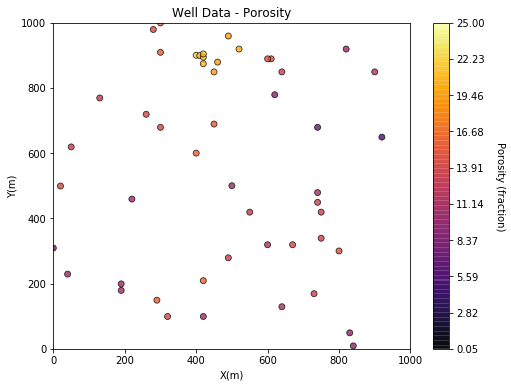

In [10]:
GSLIB.locmap(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,vmin,vmax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap,'locmap_Porosity')

Look carefully, and you'll notice the the spatial samples are more dense in the high porosity regions and lower in the low porosity regions.  There is preferential sampling.  We cannot use the naive statistics to represent this region.  We have to correct for the clustering of the samples in the high porosity regions. 

Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.   

Let's check out the declus program reimplimented from GSLIB.

In [175]:
wmin = 0.0; wmax = 3.0
noff = 3
csize = 50.0

# interactive calculation of the sample set (control of source parametric distribution and number of samples)
style = {'description_width': 'initial'}
l = widgets.Text(value='                                              Cell-based Declustering, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
csize = widgets.FloatSlider(min = 5.0, max = 10000, value = 100.0, step = 20.0, description = 'Cell Size',style=style,orientation='horizontal',
                          layout=Layout(width='250px', height='50px'),continuous_update = False)
csize.style.handle_color = 'gray'

noff = widgets.IntSlider(min=1, max = 30, value = 5, step = 5, description = 'Number of Offsets',style=style,
                        orientation='horizontal',layout=Layout(width='250px', height='50px'),continuous_update=False)
noff.style.handle_color = 'gray'

uipars = widgets.HBox([csize,noff],) 
ui = widgets.VBox([l,uipars],)

def f_make_declus(csize,noff,): # function to take parameters, make sample and plot
    
    wts =  declus(df,'X','Y',noff=noff,csize=csize)*len(df)
    avg_wts = np.average(wts,axis=1)
    
    plt.subplot(131)
    im = plt.scatter(df['X'],df['Y'],c=wts[:,0],cmap=cmap,vmin=wmin,vmax=wmax,alpha=0.8,linewidths=0.8,
            verts=None,edgecolors="black",)
    plt.title('Spatial Sample Data with Weights')
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(wmin, wmax, 10))
    cbar.set_label('Weights',rotation=270, labelpad=20)
     
    if csize < 1000:
        major_ticks = np.arange(0, 1001, csize)
        plt.gca().set_xticks(major_ticks); plt.gca().set_yticks(major_ticks)
        plt.grid()   

    plt.subplot(132)
    plt.hist(df['Porosity'],color='red',alpha=0.4,bins = np.linspace(vmin,vmax,20),edgecolor = 'black',label = 'Naive')
    plt.hist(df['Porosity'],weights = avg_wts,color='gray',alpha=0.4,bins = np.linspace(vmin,vmax,20),edgecolor = 'black',label= 'Weighted')
    plt.ylabel('Frequency'); plt.xlabel('Porosity (%)'); plt.title('Naive and Declustered Distributions')
    plt.legend()
    
    plt.xlim(0,30); plt.ylim(0.0,int(len(df)*0.5))
    
    avg = np.average(df['Porosity'])
    declus_avg = np.average(df['Porosity'],weights = avg_wts)
    P10 = weighted_percentile(df['Porosity'],10,weights=np.ones(len(df)))
    P90 = weighted_percentile(df['Porosity'],90,weights=np.ones(len(df)))
    
    plt.gca().add_patch(Rectangle((21.7,len(df)*0.345),7.8,len(df)*0.07,facecolor='white',edgecolor='black',linewidth=0.5)); 
    plt.text(22,len(df)*0.4,'Naive Mean   ' + str(round(avg,1))); 
    plt.text(22,len(df)*0.38,'Declus. Mean ' + str(round(declus_avg,1))); 
    plt.text(22,len(df)*0.36,'Correction    ' + str(round((declus_avg-avg)/avg*100,0)) + '%'); 
    
    plt.gca().add_patch(Rectangle((21.7,len(df)*0.235),4.5,len(df)*0.08,facecolor='white',edgecolor='black',linewidth=0.5)); 
    plt.text(22,len(df)*0.3,'Mean ' + str(round(np.average(df['Porosity'],weights = avg_wts),1))); 
    plt.text(22,len(df)*0.28,'P90    ' + str(round(P90,1))); 
    plt.text(22,len(df)*0.26,'P10    ' + str(round(P10,1))); 
    plt.text(22,len(df)*0.24,'n        ' + str(len(df)))

    plt.plot([avg,avg],[0.0,45],color = 'red')    
    plt.plot([P10,P10],[0.0,45],color = 'black',linestyle='dashed')
    plt.plot([declus_avg,declus_avg],[0.0,45],color = 'black')
    plt.plot([P90,P90],[0.0,45],color = 'black',linestyle='dashed')
    
    plt.subplot(133)
    plt.boxplot(wts.T)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
    for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(8)
    plt.scatter(np.linspace(1,len(df),len(df)),avg_wts,color='blue',alpha=0.8,marker='x',s=50,linewidth=1,label='Average')
    plt.xlabel('Data Index'); plt.ylabel('Data Weight Over Cell Mesh Offsets'); plt.title('Weights Variation Over Random Cell Mesh Offsets')
    plt.xlim(0,len(df)+1); #plt.ylim(0,1.5)
    plt.legend(loc = 'lower right')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make_declus, {'csize':csize, 'noff':noff})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating


### Interactive Cell-based Declustering Demostration

* select the cell size and number of cell mesh offsets and visualize the declustering method 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

### The Inputs

* **Cell Size**: the size the of the cells in the mesh, **Number of Offsets**: number of cell mesh offsets to average to calculate the data weights 

In [174]:
display(ui, interactive_plot)                            # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 432x288 with 4 Axes>', 'i…

In [46]:
np.arange(0, 1001, 10)

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000])

#### Comments

This is an interactive demonstration of cell-based declustering to correct for sampling bias. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays and many other workflows availble at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
